do a quick (c)ommission error analysis for AVHRR vs MODIS Aqua night time pass data.

This is quite crude; it performs hotspot matchups based on 1 degree grid cells (VERY generous), and with a more reasonable 6h temporal window.

Decreasing the grid cell size does seem to make errors quite a lot worse - maybe needs more thought?
* GLobal errors averaged over all years - 1 degree cells: om = 0.74, com = 0.27
* Global errors averaged over all years - 0.5 degree cells: om = 0.78, com = 0.34

Notably though the relatively high false alarm rate (0.27) is not out of line with that for geo algorithms (22-42 %, SM Tabels B&C) reported by Hall et al 2023


* code assisted by ChatGPT.

In [1]:
import sys
import os

import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import datetime as dt
from scipy import stats
from pathlib import Path

from datetime import timedelta
from collections import defaultdict

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

fn_avhrr = dir_base / "avhrr_hotspots_masked.csv"
fn_modis_aqua_am = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_am.csv.gz"

load and unify

In [3]:
avhrr = pd.read_csv(str(fn_avhrr))
avhrr = avhrr[['lat','lon180','lon360','dt_utc','dt_lst','month','year','doy','gfed','gfed_name']]
avhrr['datetime'] = pd.to_datetime(avhrr['dt_lst'])
avhrr['dt_utc'] = pd.to_datetime(avhrr['dt_utc'])
avhrr = avhrr.rename(columns={'lat': 'latitude'})
avhrr = avhrr.rename(columns={'lon180': 'longitude'})
# remove years before 2003 (no good MODIS data)
avhrr = avhrr.loc[avhrr.year > 2002,:]

modis = pd.read_csv(str(fn_modis_aqua_am))
modis['datetime'] = pd.to_datetime(modis['dt_lst'])
modis['dt_utc'] = pd.to_datetime(modis['dt_utc'])
modis = modis.rename(columns={'lat': 'latitude'})
modis = modis.rename(columns={'lon180': 'longitude'})

In [4]:
np.unique(avhrr.year)

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016], dtype=int64)

### process

params

In [50]:
GRID_SIZE = 1  # spatial grid size in degrees
TEMPORAL_TOLERANCE_DT = timedelta(hours=6)  # ±12h temporal window
TEMPORAL_TOLERANCE = np.timedelta64(6, 'h')  # this numpy version is used for vectorized comparison at grid cell level

helper funcs

In [6]:
def assign_grid_cells(df, lat_col='latitude', lon_col='longitude', method='floor'):
    df = df.copy()
    if method == 'round':
        df['lat_bin'] = (np.round(df[lat_col] / GRID_SIZE) * GRID_SIZE).astype(float)
        df['lon_bin'] = (np.round(df[lon_col] / GRID_SIZE) * GRID_SIZE).astype(float)
    else:
        df['lat_bin'] = (np.floor(df[lat_col] / GRID_SIZE) * GRID_SIZE).astype(float)
        df['lon_bin'] = (np.floor(df[lon_col] / GRID_SIZE) * GRID_SIZE).astype(float)
    return df


def match_detections(modis_df, avhrr_df):
    """
    Compare MODIS (truth) and AVHRR detections.
    A true positive (TP) occurs when any AVHRR detection exists in the same grid cell
    within the ±12 hour temporal tolerance of a MODIS detection.
    
    False negatives (FN) are MODIS detections with no AVHRR within tolerance.
    False positives (FP) are AVHRR detections with no MODIS within tolerance.
    """
    # Organize AVHRR detections by spatial grid cell
    avhrr_lookup = defaultdict(list)
    for idx, row in avhrr_df.iterrows():
        key = (row['lat_bin'], row['lon_bin'])
        avhrr_lookup[key].append((idx, row))

    matched_avhrr_idx = set()
    matched_modis = set()
    fn_set = set()

    for midx, modis_row in modis_df.iterrows():
        key = (modis_row['lat_bin'], modis_row['lon_bin'])
        candidates = avhrr_lookup.get(key, [])

        matched = False
        for cand_idx, cand in candidates:
            if abs(modis_row['datetime'] - cand['datetime']) <= TEMPORAL_TOLERANCE_DT:
                matched = True
                matched_modis.add(midx)
                matched_avhrr_idx.add(cand_idx)
        if not matched:
            fn_set.add(midx)

    # Check AVHRR for unmatched detections
    fp_set = set()
    for idx, row in avhrr_df.iterrows():
        if idx not in matched_avhrr_idx:
            key = (row['lat_bin'], row['lon_bin'])
            # Only mark as FP if no MODIS is within tolerance
            modis_candidates = modis_df[(modis_df['lat_bin'] == key[0]) &
                                        (modis_df['lon_bin'] == key[1])]
            if all(abs(row['datetime'] - m['datetime']) > TEMPORAL_TOLERANCE_DT for _, m in modis_candidates.iterrows()):
                fp_set.add(idx)

    TP = len(matched_modis)
    FN = len(fn_set)
    FP = len(fp_set)

    return TP, FN, FP

def match_detections_vectorized(modis_df, avhrr_df):
    """
    Vectorized comparison between MODIS (truth) and AVHRR detections.
    A true positive (TP) occurs when any AVHRR detection exists in the same grid cell
    within the ±12 hour temporal tolerance of a MODIS detection.
    False negatives (FN) are MODIS detections with no AVHRR within tolerance.
    False positives (FP) are AVHRR detections with no MODIS within tolerance.
    """
    modis_df = modis_df.reset_index(drop=True).copy()
    avhrr_df = avhrr_df.reset_index(drop=True).copy()
    modis_df['index_modis'] = modis_df.index
    avhrr_df['index_avhrr'] = avhrr_df.index
    
    
    merged = pd.merge(modis_df, avhrr_df, on=['lat_bin', 'lon_bin'], suffixes=('_modis', '_avhrr'))
    merged['time_diff'] = abs(merged['datetime_modis'] - merged['datetime_avhrr'])
    
    
    matched = merged[merged['time_diff'] <= TEMPORAL_TOLERANCE_DT]
    
    
    matched_modis_idx = set(matched['index_modis'])
    matched_avhrr_idx = set(matched['index_avhrr'])
    
    
    TP = len(matched_modis_idx)
    FN = len(modis_df) - TP
    FP = len(avhrr_df) - len(matched_avhrr_idx)
    
    
    return TP, FN, FP

def compute_metrics(TP, FN, FP):
    omission_rate = FN / (TP + FN) if (TP + FN) > 0 else np.nan
    commission_rate = FP / (TP + FP) if (TP + FP) > 0 else np.nan
    return omission_rate, commission_rate


# def assign_region(df, region_mask, lat_bins, lon_bins):
#     df = df.copy()
#     region_ids = []
#     for lat, lon in zip(df['latitude'], df['longitude']):
#         lat_idx = np.digitize(lat, lat_bins) - 1
#         lon_idx = np.digitize(lon, lon_bins) - 1
#         if 0 <= lat_idx < region_mask.shape[0] and 0 <= lon_idx < region_mask.shape[1]:
#             region_ids.append(region_mask[lat_idx, lon_idx])
#         else:
#             region_ids.append(-1)
#     df['region_id'] = region_ids
#     return df



main function

In [7]:
def run_analysis(modis_df, avhrr_df, region_mask=None):
    # Ensure datetime
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

    # Assign grid cells
    modis_df = assign_grid_cells(modis_df)
    avhrr_df = assign_grid_cells(avhrr_df)

    # Add year for grouping
    modis_df['year'] = modis_df['datetime'].dt.year
    avhrr_df['year'] = avhrr_df['datetime'].dt.year

    results = []

    if region_mask is not None:
        # Define grid for region assignment
        lat_bins = np.arange(-90, 90 + GRID_SIZE, GRID_SIZE)
        lon_bins = np.arange(-180, 180 + GRID_SIZE, GRID_SIZE)

        modis_df = assign_region(modis_df, region_mask, lat_bins, lon_bins)
        avhrr_df = assign_region(avhrr_df, region_mask, lat_bins, lon_bins)

        region_ids = sorted(set(modis_df['region_id']) & set(avhrr_df['region_id']))

        for region in region_ids:
            modis_r = modis_df[modis_df['region_id'] == region]
            avhrr_r = avhrr_df[avhrr_df['region_id'] == region]

            # All years
            TP, FN, FP = match_detections(modis_r, avhrr_r)
            omission, commission = compute_metrics(TP, FN, FP)
            results.append({'region': region, 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                            'omission_rate': omission, 'commission_rate': commission})

            # Per year
            years = sorted(set(modis_r['year']) | set(avhrr_r['year']))
            for year in years:
                modis_y = modis_r[modis_r['year'] == year]
                avhrr_y = avhrr_r[avhrr_r['year'] == year]
                TP, FN, FP = match_detections(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': region, 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    else:
        # ---- Overall (multi-year) analysis ----
        print(f'doing multi-year analysis')
        TP, FN, FP = match_detections(modis_df, avhrr_df)
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})

        # ---- Per-year analysis ----
        years = sorted(set(modis_df['year']) | set(avhrr_df['year']))
        if len(years) > 1:
            for year in years:
                print(f'doing year {year}')
                modis_y = modis_df[modis_df['year'] == year]
                avhrr_y = avhrr_df[avhrr_df['year'] == year]
    
                TP, FN, FP = match_detections(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': 'Global', 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    return pd.DataFrame(results)

In [31]:
# result_df = run_analysis(modis_df=modis.loc[modis.year == 2016,:].copy(), 
#                          avhrr_df=avhrr.loc[avhrr.year == 2016,:].copy(), 
#                          region_mask=None)
# print(result_df)

doing multi-year analysis
   region year     TP     FN    FP  omission_rate  commission_rate
0  Global  All  24444  81482  9676       0.769235         0.283587


a ~0.77 omission rate is actually in line with expectations; due to the GAC resampling scheme, you only end up with information from 4 of every 15 LAC pixels (which are 1km, comparable to MODIS). so all else being equal, AVHRR should at best detect 4/15ths as much fire as modis (4/15 = 0.27, 1-0.27 = 0.73)

The detection rate should in fact be even lower, because the 4 LAC pixels are averaged to get 1 GAC pixel, which will further supress detection - easily explaining omission rate of 0.77.

More problematic is a comission rate of 0.28..?

In [34]:
#4/15

0.26666666666666666

This version allows you to run regional and global, and has substantial speed improvements by using a pandas based vectorized matching process, rather than loop iteration.

In [8]:
def run_analysis(modis_df, avhrr_df, calc_overall_error=False, regional=False):
    """
    Run omission/commission analysis.
    If regional=True, break down results by 'gfed' regions.
    Always outputs global results overall and by year.
    """
    results = []
    
    # Ensure datetime format
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

    # Assign grid cells
    modis_df = assign_grid_cells(modis_df)
    avhrr_df = assign_grid_cells(avhrr_df)

    # Add year
    modis_df['year'] = modis_df['datetime'].dt.year
    avhrr_df['year'] = avhrr_df['datetime'].dt.year

    # ---- Global analysis ----
    if calc_overall_error:
        print(f'doing global - all years. Note: This will be slow; the vectorized solution causes out of memory errors so this is run iteratively.')
        TP, FN, FP = match_detections(modis_df, avhrr_df)
        #TP, FN, FP = match_detections_vectorized(modis_df, avhrr_df) <-- causes memory errors!
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})
    else:
        print(f'skipping global - all years.')
    
    years = sorted(set(modis_df['year']).intersection(set(avhrr_df['year'])))
    print(f'\nIndividual years to run: {years}\n')
    
    for year in years:
        print(f'doing global - year {year}')
        modis_y = modis_df[modis_df['year'] == year]
        avhrr_y = avhrr_df[avhrr_df['year'] == year]
        #TP, FN, FP = match_detections(modis_y, avhrr_y)
        TP, FN, FP = match_detections_vectorized(modis_y, avhrr_y)
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})

    # ---- Regional analysis ----
    if regional:
        regions = sorted(set(modis_df['gfed']).intersection(set(avhrr_df['gfed'])))
        print(f'\nRunning regional. \nIndividual regions to run: {regions}\n')
        for region in regions:
            print(f'doing regional - all years. Region: {region}')
            modis_r = modis_df[modis_df['gfed'] == region]
            avhrr_r = avhrr_df[avhrr_df['gfed'] == region]
            #TP, FN, FP = match_detections(modis_r, avhrr_r)
            #TP, FN, FP = match_detections_vectorized(modis_r, avhrr_r)
            #omission, commission = compute_metrics(TP, FN, FP)
            gfed_name = modis_r['gfed_name'].iloc[0] if not modis_r.empty else avhrr_r['gfed_name'].iloc[0]
            #results.append({'region': gfed_name, 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
            #                'omission_rate': omission, 'commission_rate': commission})
            
            for year in sorted(set(modis_r['year']).intersection(set(avhrr_r['year']))):
                print(f'doing region {region} - year {year}')
                modis_y = modis_r[modis_r['year'] == year]
                avhrr_y = avhrr_r[avhrr_r['year'] == year]
                #TP, FN, FP = match_detections(modis_y, avhrr_y)
                TP, FN, FP = match_detections_vectorized(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': gfed_name, 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    return pd.DataFrame(results)

In [10]:
# result_df = run_analysis(modis_df=modis.loc[modis.year < 2004,:].copy(), 
#                          avhrr_df=avhrr.loc[avhrr.year < 2004,:].copy(), 
#                          regional=False)
# print(result_df)

doing global - all years
Individual years to run: [2003]
doing global - year 2003
   region  year     TP     FN      FP  omission_rate  commission_rate
0  Global   All  36391  99845  275560       0.732883         0.883344
1  Global  2003  36391  99845   14161       0.732883         0.280127


In [51]:
result_df = run_analysis(modis_df=modis.loc[:].copy(), 
                         avhrr_df=avhrr.loc[:].copy(), 
                         calc_overall_error=False,
                         regional=True)
print(result_df)
result_df.to_csv(dir_out_figures / 'error_analysis_1deg_12h_v1.csv', index=False)

skipping global - all years.

Individual years to run: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

doing global - year 2003
doing global - year 2004
doing global - year 2005
doing global - year 2006
doing global - year 2007
doing global - year 2008
doing global - year 2009
doing global - year 2010
doing global - year 2011
doing global - year 2012
doing global - year 2013
doing global - year 2014
doing global - year 2015
doing global - year 2016

Running regional. 
Individual regions to run: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

doing regional - all years. Region: 0
doing region 0 - year 2003
doing region 0 - year 2004
doing region 0 - year 2005
doing region 0 - year 2006
doing region 0 - year 2007
doing region 0 - year 2008
doing region 0 - year 2009
doing region 0 - year 2010
doing region 0 - year 2011
doing region 0 - year 2012
doing region 0 - year 2013
doing region 0 - year 2014
doing region 0 - year 2015
doing region 0 - year

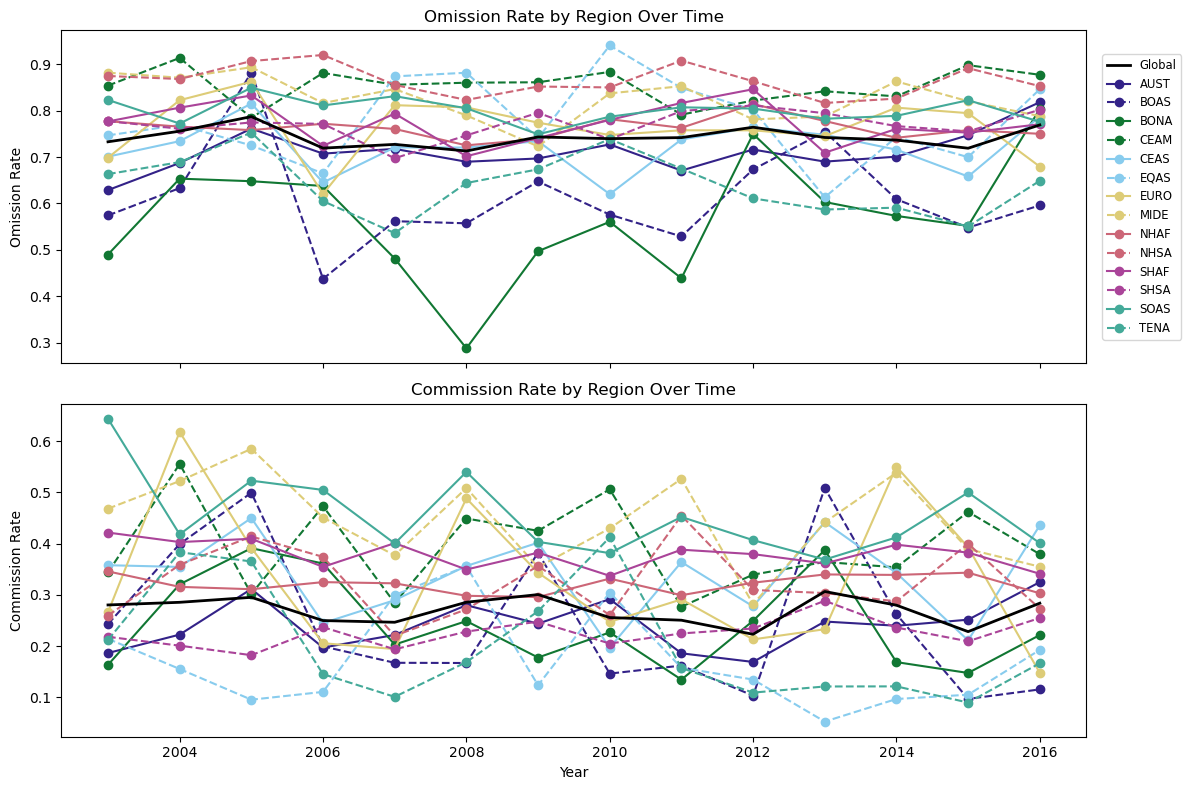

In [10]:
import itertools

# Use Paul Tol's colorblind-friendly palette (7 colors)
# Source: https://personal.sron.nl/~pault/
colorblind_colors = [
    '#332288',  # dark blue
    '#117733',  # green
    '#88CCEE',  # cyan
    '#DDCC77',  # sand
    '#CC6677',  # red
    '#AA4499',  # purple
    '#44AA99'   # teal
]

# Split global and regional data
global_df = result_df[result_df['region'] == 'Global'].copy()
regional_df = result_df[result_df['region'] != 'Global'].copy()
regional_df = regional_df[regional_df['region'] != 'Mask'].copy()

# Filter out the 'All' year row and ensure year is numeric
global_df = global_df[global_df['year'] != 'All']
regional_df = regional_df[regional_df['year'] != 'All']

global_df['year'] = pd.to_numeric(global_df['year'])
regional_df['year'] = pd.to_numeric(regional_df['year'])

regions = sorted(regional_df['region'].unique())

# Define 7 colors and 2 line styles → 14 unique combinations
#colors = plt.get_cmap('tab10').colors[:7]  # pick first 7 tab10 colors
line_styles = ['-', '--']
style_combinations = list(itertools.product(colorblind_colors, line_styles))

# Create mapping of region to (color, linestyle)
region_styles = {region: style_combinations[i] for i, region in enumerate(regions)}

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# === Omission rate ===
# Global line
ax1.plot(global_df['year'], global_df['omission_rate'], 
         color='black', linestyle='-', linewidth=2, label='Global',zorder=100)

# Regional lines
for region in regions:
    subset = regional_df[regional_df['region'] == region]
    color, style = region_styles[region]
    ax1.plot(subset['year'], subset['omission_rate'], 
             label=region, color=color, linestyle=style, marker='o')

ax1.set_ylabel('Omission Rate')
ax1.set_title('Omission Rate by Region Over Time')
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize='small')

# === Commission rate ===
# Global line
ax2.plot(global_df['year'], global_df['commission_rate'], 
         color='black', linestyle='-', linewidth=2, label='Global',zorder=100)

# Regional lines
for region in regions:
    subset = regional_df[regional_df['region'] == region]
    color, style = region_styles[region]
    ax2.plot(subset['year'], subset['commission_rate'], 
             label=region, color=color, linestyle=style, marker='o')

ax2.set_xlabel('Year')
ax2.set_ylabel('Commission Rate')
ax2.set_title('Commission Rate by Region Over Time')

plt.tight_layout()
plt.show()

fig.savefig(str(dir_out_figures / '99_com_om_timeseries_2panel.png'), dpi=300)

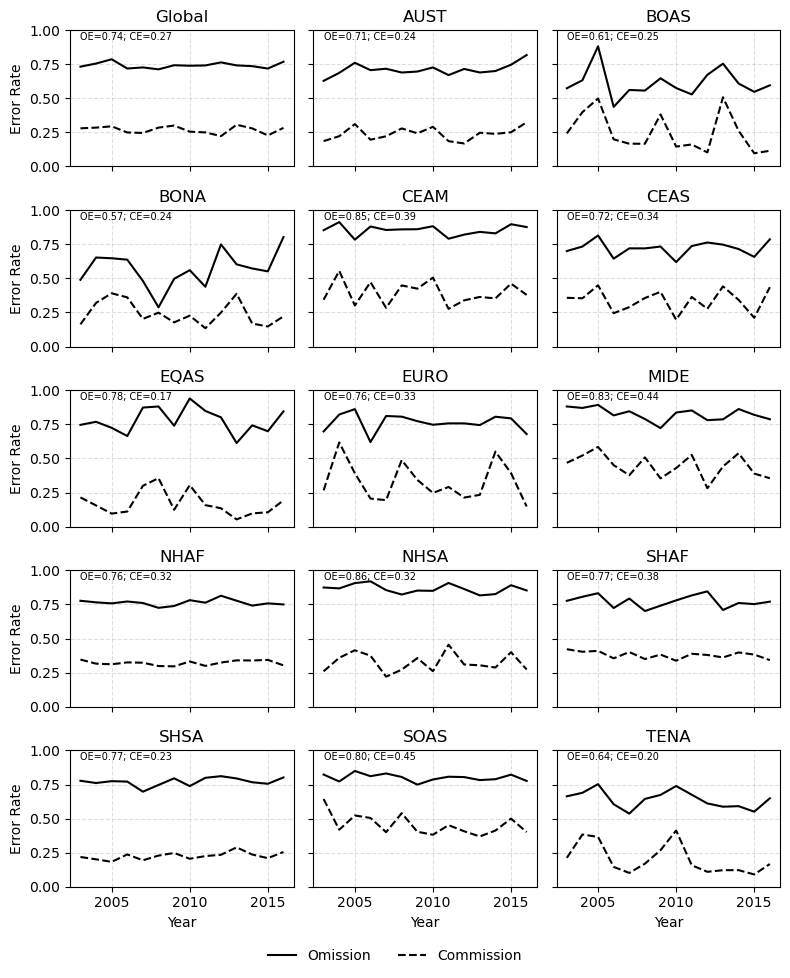

In [52]:
result_df = result_df[result_df['region'] != 'Mask'].copy()
result_df = result_df[result_df['year'] != 'All'].copy()
result_df['year'] = pd.to_numeric(result_df['year'])

all_regions = sorted(result_df['region'].unique(), key=lambda x: (x != 'Global', x))
n_panels = len(all_regions)

ncols = 3
nrows = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, region in enumerate(all_regions):
    ax = axes[i]
    region_data = result_df[result_df['region'] == region].sort_values(by='year')

    ax.plot(region_data['year'], region_data['omission_rate'],
            color='black', linestyle='-', label='Omission')
    ax.plot(region_data['year'], region_data['commission_rate'],
            color='black', linestyle='--', label='Commission')

    # Compute mean values
    mean_omission = region_data['omission_rate'].mean()
    mean_commission = region_data['commission_rate'].mean()

    # label mean values directly on the plot
    ax.text(2003, 0.95, f'OE={mean_omission:.2f}; CE={mean_commission:.2f}', 
            va='center', ha='left', fontsize=7, color='black')    
    
    # ax.text(region_data['year'].max(), mean_omission + 0.01, f'{mean_omission:.2f}', 
    #         va='bottom', ha='right', fontsize=7, color='black')
    # ax.text(region_data['year'].max(), mean_commission - 0.01, f'{mean_commission:.2f}', 
    #         va='top', ha='right', fontsize=7, color='black')
    
    ax.set_title(region)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.4)

    if i % ncols == 0:
        ax.set_ylabel('Error Rate')
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Year')

# Hide unused axes
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Shared legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
fig.savefig(str(dir_out_figures / '99_com_om_timeseries_multipanel.png'), dpi=300)

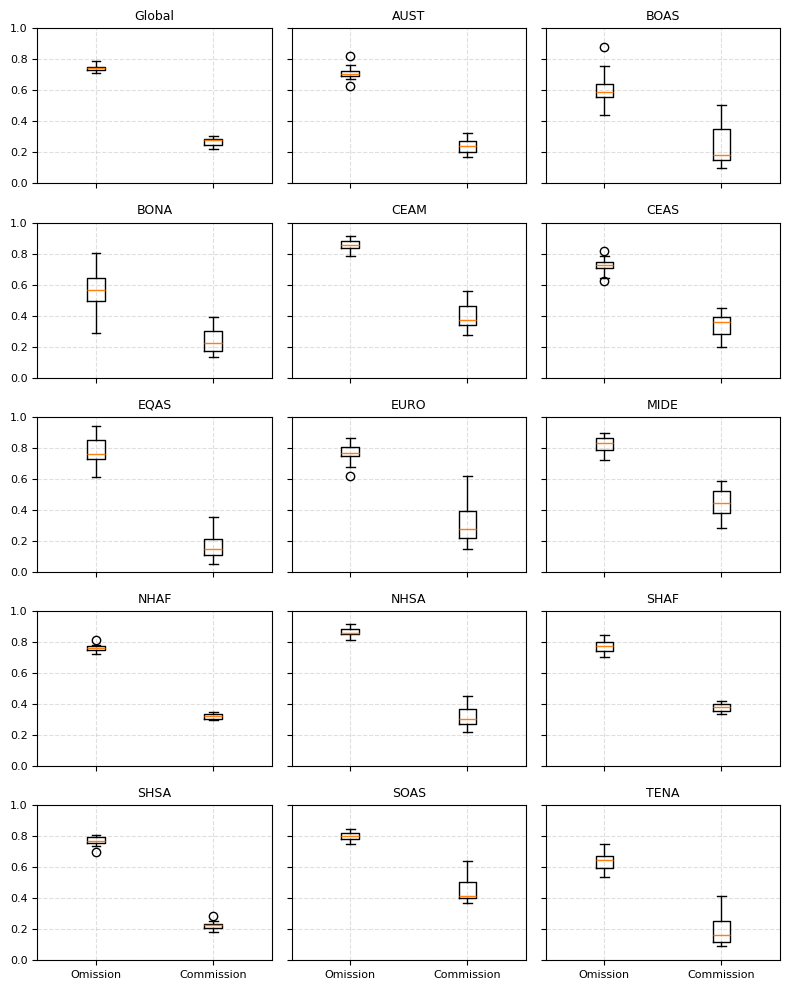

In [12]:
# Filter and prepare data
result_df = result_df[result_df['region'] != 'Mask'].copy()
result_df = result_df[result_df['year'] != 'All'].copy()
result_df['year'] = pd.to_numeric(result_df['year'])

# Sort regions, ensuring 'Global' is first
all_regions = sorted(result_df['region'].unique(), key=lambda x: (x != 'Global', x))
n_panels = len(all_regions)

# Layout settings
ncols = 3
nrows = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, region in enumerate(all_regions):
    ax = axes[i]
    data = result_df[result_df['region'] == region]
    
    omission_data = data['omission_rate'].dropna()
    commission_data = data['commission_rate'].dropna()
    
    ax.boxplot([omission_data, commission_data], positions=[1, 2])
    
    ax.set_title(region, fontsize=9)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Omission', 'Commission'], fontsize=8)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='y', labelsize=8)
   
    ax.grid(True, linestyle='--', alpha=0.4)
    
# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
fig.savefig(str(dir_out_figures / '99_com_om_boxplots.png'), dpi=300)

# 2) REVISED VERSION
* this version was made after validating the approach above. It is based on GRID CELL AGREEMENT, rather than hotspot agreement within grid cells.
* Update: On second thought, i think i prefer the method above afterall...

In [13]:
def match_detections_gridcell(modis_df, avhrr_df):
    """
    Match MODIS and AVHRR detections at the grid cell level.
    A grid cell is considered:
    - TP if it contains both MODIS and AVHRR detections within ±12h.
    - FN if MODIS is present but no AVHRR within tolerance.
    - FP if AVHRR is present but no MODIS within tolerance.
    """
    # Organize detections by grid cell
    modis_cells = modis_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(list).to_dict()
    avhrr_cells = avhrr_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(list).to_dict()

    all_cells = set(modis_cells.keys()).union(avhrr_cells.keys())

    TP = 0
    FN = 0
    FP = 0

    for cell in all_cells:
        modis_times = modis_cells.get(cell, [])
        avhrr_times = avhrr_cells.get(cell, [])

        # Check for temporal overlap
        has_match = any(
            abs(m - a) <= TEMPORAL_TOLERANCE_DT
            for m in modis_times for a in avhrr_times
        )

        if modis_times and avhrr_times and has_match:
            TP += 1
        elif modis_times and (not has_match or not avhrr_times):
            FN += 1
        elif avhrr_times and (not has_match or not modis_times):
            FP += 1

    return TP, FN, FP

def match_detections_gridcell_vectorized(modis_df, avhrr_df):
    """
    Vectorized detection matching at the grid cell level.

    Each unique grid cell is assessed for:
    - TP: both MODIS and AVHRR detections exist and have a temporal match (±12h).
    - FN: MODIS only, no AVHRR within temporal tolerance.
    - FP: AVHRR only, no MODIS within temporal tolerance.
    """

    # Group datetimes by grid cell
    modis_group = modis_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(np.array)
    avhrr_group = avhrr_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(np.array)

    modis_cells = set(modis_group.index)
    avhrr_cells = set(avhrr_group.index)
    all_cells = modis_cells.union(avhrr_cells)

    TP, FN, FP = 0, 0, 0

    for cell in all_cells:
        modis_times = modis_group.get(cell, np.array([]))
        avhrr_times = avhrr_group.get(cell, np.array([]))

        if modis_times.size > 0 and avhrr_times.size > 0:
            # Calculate all pairwise time differences
            dt_diff = np.abs(modis_times[:, None] - avhrr_times[None, :])
            matched = np.any(dt_diff <= TEMPORAL_TOLERANCE)
            if matched:
                TP += 1
            else:
                FN += 1
                FP += 1
        elif modis_times.size > 0:
            FN += 1
        elif avhrr_times.size > 0:
            FP += 1

    return TP, FN, FP

In [22]:
def run_analysis_v2(modis_df, avhrr_df, calc_overall_error=False, regional=False, gridding_method='floor'):
    """
    Run omission/commission analysis, but this time we use grid cell (rather than hotspot) based logic.
    If regional=True, break down results by 'gfed' regions.
    Always outputs global results overall and by year.
    """
    results = []
    
    # Ensure datetime format
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

    # Assign grid cells
    modis_df = assign_grid_cells(modis_df, method = gridding_method)
    avhrr_df = assign_grid_cells(avhrr_df, method = gridding_method)

    # Add year
    modis_df['year'] = modis_df['datetime'].dt.year
    avhrr_df['year'] = avhrr_df['datetime'].dt.year

    # ---- Global analysis ----
    if calc_overall_error:
        print(f'doing global - all years. Note: This will be slow; the vectorized solution causes out of memory errors so this is run iteratively.')
        TP, FN, FP = match_detections_gridcell(modis_df, avhrr_df)
        #TP, FN, FP = match_detections_vectorized(modis_df, avhrr_df) <-- causes memory errors!
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})
    else:
        print(f'skipping global - all years.')
    
    years = sorted(set(modis_df['year']).intersection(set(avhrr_df['year'])))
    print(f'\nIndividual years to run: {years}\n')
    
    for year in years:
        print(f'doing global - year {year}')
        modis_y = modis_df[modis_df['year'] == year]
        avhrr_y = avhrr_df[avhrr_df['year'] == year]
        #TP, FN, FP = match_detections(modis_y, avhrr_y)
        TP, FN, FP = match_detections_gridcell_vectorized(modis_y, avhrr_y)
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})

    # ---- Regional analysis ----
    if regional:
        regions = sorted(set(modis_df['gfed']).intersection(set(avhrr_df['gfed'])))
        print(f'\nRunning regional. \nIndividual regions to run: {regions}\n')
        for region in regions:
            print(f'doing regional - all years. Region: {region}')
            modis_r = modis_df[modis_df['gfed'] == region]
            avhrr_r = avhrr_df[avhrr_df['gfed'] == region]
            #TP, FN, FP = match_detections_gridcell(modis_r, avhrr_r)
            #TP, FN, FP = match_detections_gridcell_vectorized(modis_r, avhrr_r)
            #omission, commission = compute_metrics(TP, FN, FP)
            gfed_name = modis_r['gfed_name'].iloc[0] if not modis_r.empty else avhrr_r['gfed_name'].iloc[0]
            #results.append({'region': gfed_name, 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
            #                'omission_rate': omission, 'commission_rate': commission})
            
            for year in sorted(set(modis_r['year']).intersection(set(avhrr_r['year']))):
                print(f'doing region {region} - year {year}')
                modis_y = modis_r[modis_r['year'] == year]
                avhrr_y = avhrr_r[avhrr_r['year'] == year]
                #TP, FN, FP = match_detections_gridcell(modis_y, avhrr_y)
                TP, FN, FP = match_detections_gridcell_vectorized(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': gfed_name, 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    return pd.DataFrame(results)

In [43]:
result_df_v2 = run_analysis_v2(modis_df=modis.loc[:].copy(), 
                               avhrr_df=avhrr.loc[:].copy(), 
                               calc_overall_error=False,
                               regional=False,
                               gridding_method='floor')
print(result_df_v2)
result_df_v2.to_csv(dir_out_figures / 'error_analysis_1deg_12h_v2.csv', index=False)

skipping global - all years.

Individual years to run: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

doing global - year 2003
doing global - year 2004
doing global - year 2005
doing global - year 2006
doing global - year 2007
doing global - year 2008
doing global - year 2009
doing global - year 2010
doing global - year 2011
doing global - year 2012
doing global - year 2013
doing global - year 2014
doing global - year 2015
doing global - year 2016
    region  year    TP    FN    FP  omission_rate  commission_rate
0   Global  2003  4283  7229  4166       0.627953         0.493076
1   Global  2004  3889  6963  4120       0.641633         0.514421
2   Global  2005  3384  7524  4151       0.689769         0.550896
3   Global  2006  4035  7095  3701       0.637466         0.478413
4   Global  2007  4425  7042  3534       0.614110         0.444026
5   Global  2008  4364  6856  3976       0.611052         0.476739
6   Global  2009  3553  6526  3612      

In [44]:
print(result_df.loc[result_df.region == 'Global'].omission_rate.mean(), result_df.loc[result_df.region == 'Global'].commission_rate.mean())
print(result_df_v2.loc[result_df_v2.region == 'Global'].omission_rate.mean(), result_df_v2.loc[result_df_v2.region == 'Global'].commission_rate.mean())


0.7783657512812231 0.3345759229671263
0.644667039306919 0.4860599015076941


# ========================
# testing to make sure the matching code works
* this testing determined that 1) despite the gridding, each hotspot is still being used as the smallest unit for the contingency analysis, not the grid cells and 2) 'floor' for binning the grid cells might be better replaced by 'round' 

get a random day to reduce the number of fires we are looking at

In [124]:
asub = avhrr.loc[(avhrr.year == 2016) & (avhrr.doy == 222), :].copy()
msub = modis.loc[(modis.year == 2016) & (modis.doy == 222), :].copy()

In [125]:
a_y = asub.latitude.values
a_x = asub.longitude.values
a_x360 = asub.lon360.values

m_y = msub.latitude.values
m_x = msub.longitude.values
m_x360 = msub.lon360.values

find a managable area to manually validate - California is a good candidate for DoY 222 in 2016

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


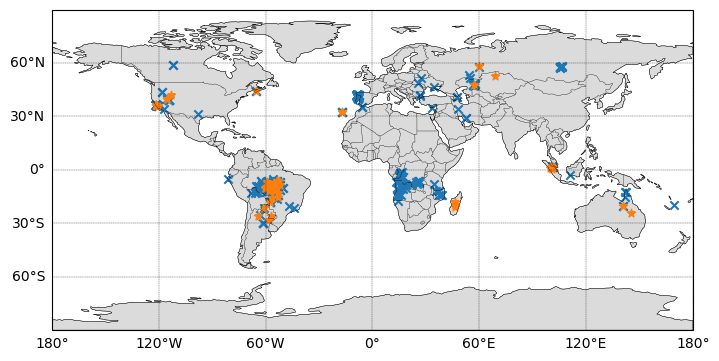

In [126]:
mm = 1/25.4
fig, ax, mesh = utils.geo_plot_v2(figsize=(210*mm,297*mm),
                                extent = [-180, 180, -90, 90],
                                grid_options={'color': 'k', 'linestyle': '--', 'alpha': 0.95, 
                                              'linewidth': 0.25, 'draw_labels': True},
                                draw_features=['land', 'coast', 'countries']
                             )


ax.scatter(y=m_y,
           x=m_x,
           marker='x')

ax.scatter(y=a_y,
           x=a_x,
           marker='*')

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


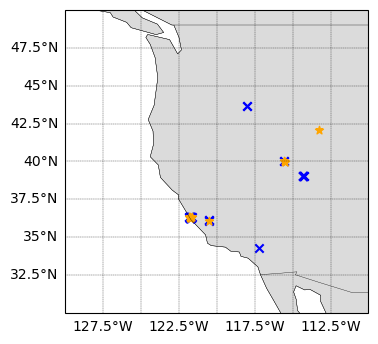

In [138]:
fig, ax, mesh = utils.geo_plot_v2(figsize=(100*mm,100*mm),
                                #extent = [-124, -112, 44, 34],
                                  extent = [-130, -110, 50, 30],
                                #extent = [-122, -121.6, 36.5, 36],
                                grid_options={'color': 'k', 'linestyle': '--', 'alpha': 0.95, 
                                              'linewidth': 0.25, 'draw_labels': True},
                                draw_features=['land', 'coast', 'countries']
                             )



ax.scatter(y=m_y,
           x=m_x,
           marker='x',c='blue')

ax.scatter(y=a_y,
           x=a_x,
           marker='*',c='orange')

subset further to just these fires

In [70]:
asub2 = asub.loc[(asub.latitude < 50) & 
                (asub.latitude > 30) & 
                (asub.longitude < -110) &
                (asub.longitude > -130), :].copy()
msub2 = msub.loc[(msub.latitude < 50) & 
                (msub.latitude > 30) & 
                (msub.longitude < -110) &
                (msub.longitude > -130), :].copy()
#plt.scatter(asub2.longitude, asub2.latitude)
#plt.scatter(msub2.longitude, msub2.latitude)

In [180]:
# def assign_grid_cells(df, lat_col='latitude', lon_col='longitude'):
#     df = df.copy()
#     df['lat_bin'] = (np.round(df[lat_col] / GRID_SIZE) * GRID_SIZE).astype(float)
#     df['lon_bin'] = (np.round(df[lon_col] / GRID_SIZE) * GRID_SIZE).astype(float)
#     return df

def match_detections_gridcell(modis_df, avhrr_df):
    """
    Match MODIS and AVHRR detections at the grid cell level.
    A grid cell is considered:
    - TP if it contains both MODIS and AVHRR detections within ±12h.
    - FN if MODIS is present but no AVHRR within tolerance.
    - FP if AVHRR is present but no MODIS within tolerance.
    """
    # Organize detections by grid cell
    modis_cells = modis_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(list).to_dict()
    avhrr_cells = avhrr_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(list).to_dict()

    all_cells = set(modis_cells.keys()).union(avhrr_cells.keys())

    TP = 0
    FN = 0
    FP = 0

    for cell in all_cells:
        modis_times = modis_cells.get(cell, [])
        avhrr_times = avhrr_cells.get(cell, [])

        # Check for temporal overlap
        has_match = any(
            abs(m - a) <= TEMPORAL_TOLERANCE_DT
            for m in modis_times for a in avhrr_times
        )

        if modis_times and avhrr_times and has_match:
            TP += 1
        elif modis_times and (not has_match or not avhrr_times):
            FN += 1
        elif avhrr_times and (not has_match or not modis_times):
            FP += 1

    return TP, FN, FP

def match_detections_gridcell_vectorized(modis_df, avhrr_df):
    """
    Vectorized detection matching at the grid cell level.

    Each unique grid cell is assessed for:
    - TP: both MODIS and AVHRR detections exist and have a temporal match (±12h).
    - FN: MODIS only, no AVHRR within temporal tolerance.
    - FP: AVHRR only, no MODIS within temporal tolerance.
    """

    # Group datetimes by grid cell
    modis_group = modis_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(np.array)
    avhrr_group = avhrr_df.groupby(['lat_bin', 'lon_bin'])['datetime'].apply(np.array)

    modis_cells = set(modis_group.index)
    avhrr_cells = set(avhrr_group.index)
    all_cells = modis_cells.union(avhrr_cells)

    TP, FN, FP = 0, 0, 0

    for cell in all_cells:
        modis_times = modis_group.get(cell, np.array([]))
        avhrr_times = avhrr_group.get(cell, np.array([]))

        if modis_times.size > 0 and avhrr_times.size > 0:
            # Calculate all pairwise time differences
            dt_diff = np.abs(modis_times[:, None] - avhrr_times[None, :])
            matched = np.any(dt_diff <= TEMPORAL_TOLERANCE)
            if matched:
                TP += 1
            else:
                FN += 1
                FP += 1
        elif modis_times.size > 0:
            FN += 1
        elif avhrr_times.size > 0:
            FP += 1

    return TP, FN, FP

In [183]:

modis_df = msub2.copy()
avhrr_df = asub2.copy()
print(f'modis_df shape:{modis_df.shape}, avhrr_df shape {avhrr_df.shape}')
results = []
calc_overall_error = True

# Ensure datetime format
modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

# Assign grid cells
modis_df = assign_grid_cells(modis_df)
avhrr_df = assign_grid_cells(avhrr_df)

# Add year
modis_df['year'] = modis_df['datetime'].dt.year
avhrr_df['year'] = avhrr_df['datetime'].dt.year

print(f'modis_df shape:{modis_df.shape}, avhrr_df shape {avhrr_df.shape}')

# ---- Global analysis ----
if calc_overall_error:
    print(f'doing global - all years. Note: This will be slow; the vectorized solution causes out of memory errors so this is run iteratively.')
    TP, FN, FP = match_detections_vectorized(modis_df, avhrr_df)
    #TP, FN, FP = match_detections_vectorized(modis_df, avhrr_df) <-- causes memory errors!
    omission, commission = compute_metrics(TP, FN, FP)
    results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                    'omission_rate': omission, 'commission_rate': commission})
else:
    print(f'skipping global - all years.')
print(f'modis_df shape:{modis_df.shape}, avhrr_df shape {avhrr_df.shape}')

results

modis_df shape:(40, 13), avhrr_df shape (12, 11)
modis_df shape:(40, 15), avhrr_df shape (12, 13)
doing global - all years. Note: This will be slow; the vectorized solution causes out of memory errors so this is run iteratively.
modis_df shape:(40, 15), avhrr_df shape (12, 13)


[{'region': 'Global',
  'year': 'All',
  'TP': 3,
  'FN': 3,
  'FP': 1,
  'omission_rate': 0.5,
  'commission_rate': 0.25}]

looks like results is still counting every hotspot, not each grid cell match?

In [156]:
#results

[{'region': 'Global',
  'year': 'All',
  'TP': 30,
  'FN': 10,
  'FP': 1,
  'omission_rate': 0.25,
  'commission_rate': 0.03225806451612903}]

In [158]:
a_bins = avhrr_df[['lat_bin','lon_bin']].drop_duplicates()
m_bins = modis_df[['lat_bin','lon_bin']].drop_duplicates()
m_bins.shape, a_bins.shape

((6, 2), (4, 2))

In [159]:
a_bin_y = a_bins.lat_bin.values
a_bin_x = a_bins.lon_bin.values
#a_x360 = asub.lon360.values

m_bin_y = m_bins.lat_bin.values
m_bin_x = m_bins.lon_bin.values
#m_x360 = msub.lon360.values

C:\Users\mdejong\AppData\Local\anaconda3\envs\py39-av\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


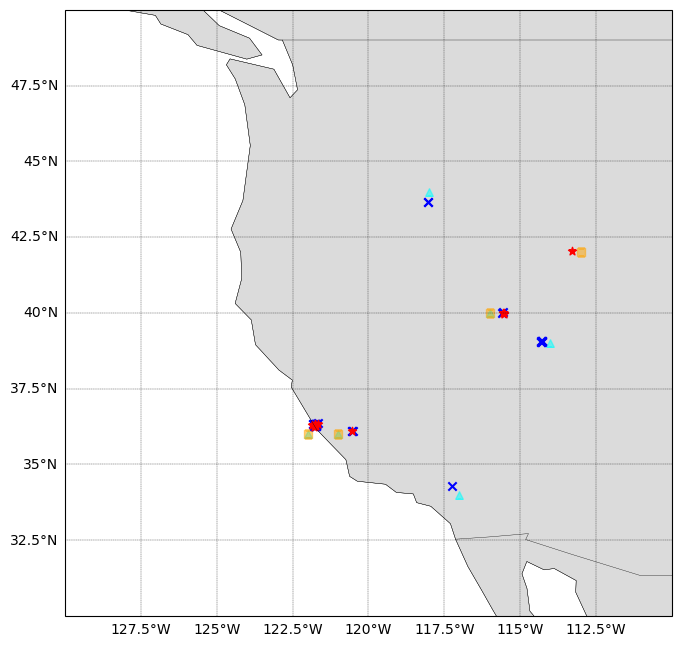

In [177]:
fig, ax, mesh = utils.geo_plot_v2(figsize=(200*mm,200*mm),
                                extent = [-130, -110, 50, 30],
                                #extent = [-114.5, -114.1, 39.15, 39],
                                grid_options={'color': 'k', 'linestyle': '--', 'alpha': 0.95, 
                                              'linewidth': 0.25, 'draw_labels': True},
                                draw_features=['land', 'coast', 'countries']
                             )



ax.scatter(y=m_bin_y,
           x=m_bin_x,
           marker='^', s=30, alpha=0.5,c='cyan')

ax.scatter(y=a_bin_y,
           x=a_bin_x,
           marker='s', s=30, alpha=0.5,c='orange')

ax.scatter(y=m_y,
           x=m_x,
           marker='x',c='blue')
ax.scatter(y=a_y,
           x=a_x,
           marker='*',c='red')